<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study2/blob/main/marchine3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-model-optimization

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_model_optimization.sparsity import keras as sparsity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
# loading img
import PIL.Image as Image

p = '/content/drive/MyDrive/deajeon_motor'
os.chdir(p)

# Resize image function
def resize_img(img, size):
    return img.resize(size)

def load_img(file_path):
    data = []
    for f in os.listdir(file_path):
        img = Image.open(p + file_path[1:] + '/' + f).convert('RGB')
        data.append(resize_img(img, (64, 64)))
    return data

# Convert images to arrays
def img_to_array(img):
    return np.array(img, dtype='float32') / 255.0

In [ ]:
# Define paths and load data
train_normal = load_img('./train/normal')
test_normal = load_img('./test/normal')
val_normal = load_img('./validation/normal')

train_fault = load_img('./train/fault')
test_fault = load_img('./test/fault')
val_fault = load_img('./validation/fault')

In [ ]:
len(train_normal), len(test_normal), len(val_normal), len(train_fault), len(test_fault), len(val_fault)

(3000, 3000, 1500, 3000, 3000, 1500)

In [ ]:
def img_to_array(img):
    return np.array(img, dtype='float32') / 255.0

train_normal_arr, train_normal_sol = np.array([img_to_array(normal) for normal in train_normal]), np.array([1] * len(train_normal))
test_normal_arr, test_normal_sol = np.array([img_to_array(normal) for normal in test_normal]), np.array([1] * len(test_normal))
val_normal_arr, val_normal_sol = np.array([img_to_array(normal) for normal in val_normal]), np.array([1] * len(val_normal))

train_fault_arr, train_fault_sol = np.array([img_to_array(fault) for fault in train_fault]), np.array([0] * len(train_fault))
test_fault_arr, test_fault_sol = np.array([img_to_array(fault) for fault in test_fault]), np.array([0] * len(test_fault))
val_fault_arr, val_fault_sol = np.array([img_to_array(fault) for fault in val_fault]), np.array([0] * len(val_fault))

# Combine normal and fault data
train_img, train_sol = np.concatenate((train_normal_arr, train_fault_arr)), np.concatenate((train_normal_sol, train_fault_sol))
test_img, test_sol = np.concatenate((test_normal_arr, test_fault_arr)), np.concatenate((test_normal_sol, test_fault_sol))
val_img, val_sol = np.concatenate((val_normal_arr, val_fault_arr)), np.concatenate((val_normal_sol, val_fault_sol))


In [ ]:
# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile the model
model = create_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_img, train_sol, epochs=30, validation_data=(val_img, val_sol))

# Evaluate the model on the test data
original_score = model.evaluate(test_img, test_sol)
print(f'Original model test loss: {original_score[0]}, test accuracy: {original_score[1]}')

Epoch 1/30
188/188 [==============================] - 69s 351ms/step - loss: 0.2869 - accuracy: 0.8540 - val_loss: 0.0421 - val_accuracy: 0.9897
Epoch 2/30
188/188 [==============================] - 52s 279ms/step - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.0473 - val_accuracy: 0.9867
Epoch 3/30
188/188 [==============================] - 48s 255ms/step - loss: 0.0288 - accuracy: 0.9917 - val_loss: 0.0145 - val_accuracy: 0.9970
Epoch 4/30
188/188 [==============================] - 47s 250ms/step - loss: 0.0186 - accuracy: 0.9953 - val_loss: 0.2137 - val_accuracy: 0.9203
Epoch 5/30
188/188 [==============================] - 51s 270ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.0184 - val_accuracy: 0.9943
Epoch 6/30
188/188 [==============================] - 46s 247ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0539 - val_accuracy: 0.9807
Epoch 7/30
188/188 [==============================] - 50s 268ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0144 - val_ac

In [ ]:
# Prune the model
batch_size = 32
epochs = 30
validation_split = 0.1

num_images = train_img.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.90,
                                                 begin_step=0,
                                                 end_step=end_step)
}

pruned_model = sparsity.prune_low_magnitude(create_model(), **pruning_params)

# Compile the pruned model
pruned_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the pruned model
callbacks = [sparsity.UpdatePruningStep()]

pruned_history = pruned_model.fit(train_img, train_sol, epochs=epochs, batch_size=batch_size,
                                  validation_split=validation_split, callbacks=callbacks)

Epoch 1/30
169/169 [==============================] - 46s 234ms/step - loss: 0.2539 - accuracy: 0.8646 - val_loss: 0.0223 - val_accuracy: 0.9933
Epoch 2/30
169/169 [==============================] - 42s 249ms/step - loss: 0.0138 - accuracy: 0.9967 - val_loss: 0.0104 - val_accuracy: 0.9983
Epoch 3/30
169/169 [==============================] - 40s 238ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 4/30
169/169 [==============================] - 39s 231ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0248 - val_accuracy: 0.9900
Epoch 5/30
169/169 [==============================] - 41s 241ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 6.1398e-04 - val_accuracy: 1.0000
Epoch 6/30
169/169 [==============================] - 38s 227ms/step - loss: 0.0203 - accuracy: 0.9943 - val_loss: 0.0037 - val_accuracy: 0.9983
Epoch 7/30
169/169 [==============================] - 40s 240ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0740 - va

In [ ]:
import tensorflow_model_optimization as tfmot

# Strip pruning wrappers
final_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Save the original and pruned models
model.save('original_model.keras')
final_pruned_model.save('pruned_model_final.keras')

In [ ]:
# Evaluate the pruned model on the test data
pruned_score = pruned_model.evaluate(test_img, test_sol)
print(f'Pruned model test loss: {pruned_score[0]}, test accuracy: {pruned_score[1]}')

188/188 [==============================] - 13s 68ms/step - loss: 0.0031 - accuracy: 0.9990
Pruned model test loss: 0.0031054457649588585, test accuracy: 0.9990000128746033


In [ ]:
# Save the original and pruned models in Keras format
model.save('original_model.keras')
final_pruned_model.save('pruned_model_final.keras')

# Get the file sizes
original_model_size = os.path.getsize('original_model.keras')
pruned_model_size = os.path.getsize('pruned_model_final.keras')

print(f'Original model size: {original_model_size / 1024:.2f} KB')
print(f'Pruned model size: {pruned_model_size / 1024:.2f} KB')

Original model size: 8053.44 KB
Pruned model size: 2699.36 KB


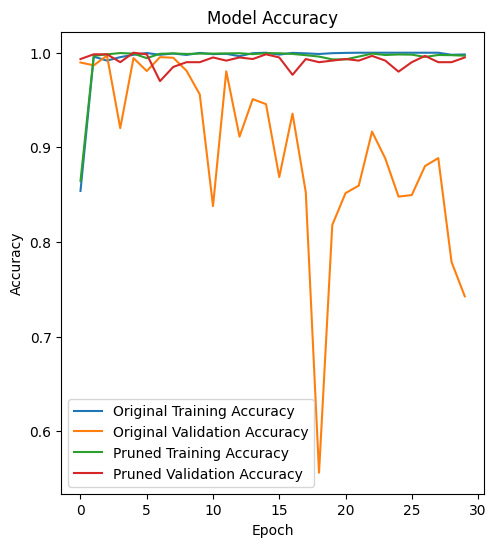

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Original Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Original Validation Accuracy')
plt.plot(pruned_history.history['accuracy'], label='Pruned Training Accuracy')
plt.plot(pruned_history.history['val_accuracy'], label='Pruned Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

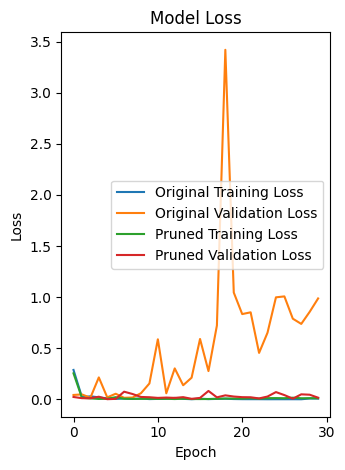

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Original Training Loss')
plt.plot(history.history['val_loss'], label='Original Validation Loss')
plt.plot(pruned_history.history['loss'], label='Pruned Training Loss')
plt.plot(pruned_history.history['val_loss'], label='Pruned Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##5.3 혼동 행렬 및 분류 보고서


모델의 예측 성능을 더 세부적으로 평가하기 위해 혼동 행렬과 분류 보고서를 작성하였습니다.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(test_img) > 0.5).astype(int).reshape(-1)
conf_matrix = confusion_matrix(test_sol, y_pred)
class_report = classification_report(test_sol, y_pred)
print("Confusion Matrix for Original Model:")
print(conf_matrix)
print("Classification Report for Original Model:")
print(class_report)

y_pred_pruned = (pruned_model.predict(test_img) > 0.5).astype(int).reshape(-1)
conf_matrix_pruned = confusion_matrix(test_sol, y_pred_pruned)
class_report_pruned = classification_report(test_sol, y_pred_pruned)
print("Confusion Matrix for Pruned Model:")
print(conf_matrix_pruned)
print("Classification Report for Pruned Model:")
print(class_report_pruned)

188/188 [==============================] - 11s 59ms/step
Confusion Matrix for Original Model:
[[3000    0]
 [ 567 2433]]
Classification Report for Original Model:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3000
           1       1.00      0.81      0.90      3000

    accuracy                           0.91      6000
   macro avg       0.92      0.91      0.90      6000
weighted avg       0.92      0.91      0.90      6000

188/188 [==============================] - 13s 67ms/step
Confusion Matrix for Pruned Model:
[[3000    0]
 [   6 2994]]
Classification Report for Pruned Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



##5.4 ROC-AUC 곡선

모델의 분류 성능을 평가하기 위해 ROC-AUC 곡선을 작성하였습니다.

188/188 [==============================] - 11s 59ms/step


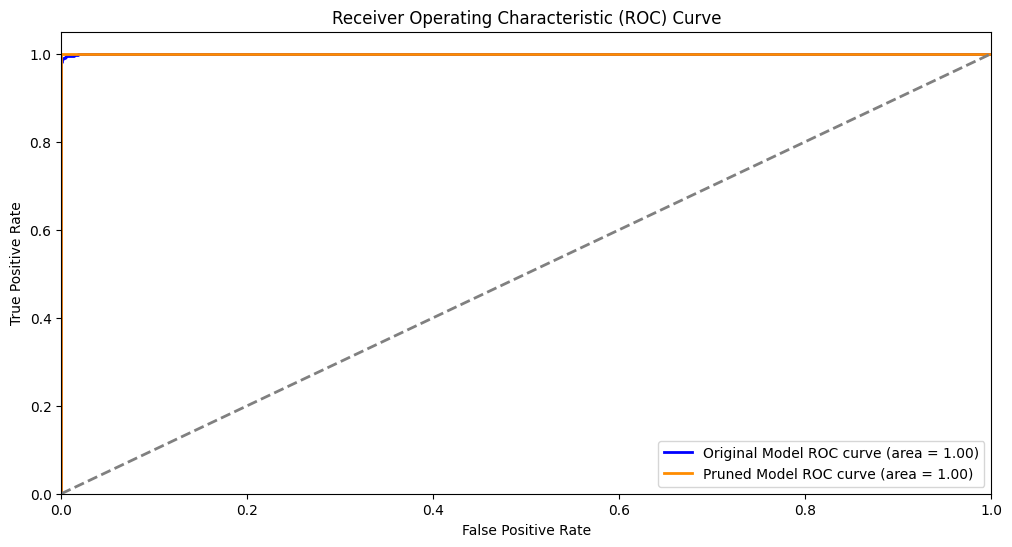

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(test_img).ravel()
fpr, tpr, thresholds = roc_curve(test_sol, y_pred_prob)
roc_auc = auc(fpr, tpr)

y_pred_prob_pruned = pruned_model.predict(test_img).ravel()
fpr_pruned, tpr_pruned, thresholds_pruned = roc_curve(test_sol, y_pred_prob_pruned)
roc_auc_pruned = auc(fpr_pruned, tpr_pruned)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Original Model ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_pruned, tpr_pruned, color='darkorange', lw=2, label='Pruned Model ROC curve (area = %0.2f)' % roc_auc_pruned)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##5.5 F1-Score

모델의 정밀도와 재현율의 조화평균인 F1-Score를 계산하여 비교하였습니다.

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(test_sol, y_pred)
print(f"F1-score for Original Model: {f1}")

f1_pruned = f1_score(test_sol, y_pred_pruned)
print(f"F1-score for Pruned Model: {f1_pruned}")

F1-score for Original Model: 0.8956377691882939
F1-score for Pruned Model: 0.998998998998999


##5.6 추론 시간

원래 모델과 가지치기된 모델의 추론 시간을 측정하였습니다.

In [ ]:
import time

start_time = time.time()
model.predict(test_img)
end_time = time.time()
original_inference_time = end_time - start_time
print(f"Original Model Inference Time: {original_inference_time} seconds")

start_time = time.time()
pruned_model.predict(test_img)
end_time = time.time()
pruned_inference_time = end_time - start_time
print(f"Pruned Model Inference Time: {pruned_inference_time} seconds")

188/188 [==============================] - 12s 62ms/step
Original Model Inference Time: 12.361459732055664 seconds
188/188 [==============================] - 13s 70ms/step
Pruned Model Inference Time: 20.88606905937195 seconds


5.7 메모리 사용량

원래 모델과 가지치기된 모델의 메모리 사용량을 측정하였습니다.

In [ ]:
import tracemalloc

tracemalloc.start()
model.predict(test_img)
current, peak = tracemalloc.get_traced_memory()
print(f"Original Model Memory Usage: Current={current / 10**6:.2f}MB; Peak={peak / 10**6:.2f}MB")
tracemalloc.stop()

tracemalloc.start()
pruned_model.predict(test_img)
current, peak = tracemalloc.get_traced_memory()
print(f"Pruned Model Memory Usage: Current={current / 10**6:.2f}MB; Peak={peak / 10**6:.2f}MB")
tracemalloc.stop()

188/188 [==============================] - 17s 89ms/step
Original Model Memory Usage: Current=0.23MB; Peak=294.96MB
188/188 [==============================] - 14s 77ms/step
Pruned Model Memory Usage: Current=0.23MB; Peak=295.09MB
